# VIPERS SHAM Project

This notebook is part of the VIPERS-SHAM project:
http://arxiv.org/abs/xxxxxxx

Copyright 2019 by Ben Granett, granett@gmail.com
All rights reserved.
This file is released under the "MIT License Agreement". Please see the LICENSE
file that should have been included as part of this package.

In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
plt.style.use("small.style")
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter, MultipleLocator
from matplotlib import colors,cm

import logging
logging.basicConfig(level=logging.INFO)

from scipy import interpolate, integrate

import numpy as np

import growthcalc
import load
import emulator

In [2]:
samples = ['sdss','L1','L2','L3','L4']
redshifts = {'sdss':.06, 'L1':0.6, 'L2':0.7, 'L3':0.8, 'L4':0.9}
rmin = 1
n_components = 2
thresh = 0.1

In [3]:
def chi2_svd(d, cmat, thresh=0.1):
    """ """
    u,s,v = np.linalg.svd(cmat)
    
    cut = np.abs(s).max()*thresh
    o = np.abs(s)>cut
    s = s[o]
    v = v[o]
        
    d_ = np.dot(v, d)
    chi2 = np.sum(d_**2/s)
    return chi2
    

In [4]:
def limits(x, y, t=1):
    best = y.argmin()
    x0 = x[best]
    ybest = y[best]
    thresh = ybest + t
        
    yup = y[best:]
    b = best + yup.searchsorted(thresh)
    
    ydown = y[:best][::-1]
    a = best - ydown.searchsorted(thresh)
    
    if a < 0:
        a = None
    if b >= len(x):
        b = None
    
    return best, a, b

In [5]:
r_sdss,wp_sdss,cov_sdss = load.load_sdss()
sel = r_sdss > rmin
r_sdss = r_sdss[sel]
wp_sdss = wp_sdss[sel]
cov_sdss = cov_sdss[sel,:][:,sel]

data = [(r_sdss, wp_sdss, cov_sdss)]

for sample in samples[1:]:
    r,wp = np.loadtxt('../data/vipers/wp_sM{sample}.txt'.format(sample=sample[1]), unpack=True)
    cmat = np.loadtxt('../data/vipers/cov_{sample}.txt'.format(sample=sample))
    sel = r > rmin
    r = r[sel]
    wp = wp[sel]
    cmat = cmat[sel,:][:,sel]
    data.append((r,wp,cmat))

In [6]:
shamdata = {}
for sample in ['sdss','L1','L2','L3','L4']:
    sham = load.load_sham(sample=sample, template="../data/sham400/nz_{sample}/wp_snap{snapshot:7.5f}.txt")
    snapshots = sham.keys()
    snapshots.sort()
    for key in snapshots:
        r, wp = sham[key]
        sel = r > rmin
        r = r[sel]
        wp = wp[sel]
        if not sample in shamdata:
            shamdata[sample] = []
        shamdata[sample].append((key, r, wp))


a_samples = []
interpolators = []
for key in samples:
    y = []
    x = []
    for a,r,w in shamdata[key]:
        sel = r > rmin
        r = r[sel]
        y.append(w[sel])
        x.append(a)
    y = np.array(y)
    x = np.array(x)
    f = emulator.WpInterpolator(x, r, y, n_components)
    interpolators.append(f)
    a_samples.append(1./(1+redshifts[key]))
a_samples = np.array(a_samples)

INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.53000.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.62230.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.66430.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.71240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.77240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.83240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.90740.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap1.00000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.44200.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.50000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.53000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.55630.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.58640.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.62230.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.66430.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.71240.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.77240.tx

INFO:root:growth range -0.632121 5.000000
INFO:root:growth sig8 0.822800


[(2.4659141638576205, 0.3), (1.9536693363880233, 0.35), (1.5644318237729828, 0.39999999999999997), (1.2564749170491742, 0.44999999999999996), (1.0047229253986876, 0.49999999999999994), (0.7931676574650158, 0.5499999999999999), (0.6110659843495065, 0.5999999999999999), (0.4509071600300166, 0.6499999999999999), (0.3072150524144568, 0.7), (0.17585004536021157, 0.7499999999999999), (0.05353164556951569, 0.7999999999999998), (-0.06248205620771032, 0.8499999999999999), (-0.1746640486968089, 0.8999999999999999), (-0.28548255675657996, 0.95), (-0.39777638703430845, 0.9999999999999998)]
min chi2 sdss 0.000991218216033665
min chi2 sdss 0.2917833971752672
min chi2 L1 0.7588330146870028
min chi2 L1 0.8253945037108826
min chi2 L2 0.05372288357067075
min chi2 L2 0.08807604333857713
min chi2 L3 0.46947042394143756
min chi2 L3 0.48548863921054697


min chi2 L4 1.1259301001165847
min chi2 L4 1.0319590361934217


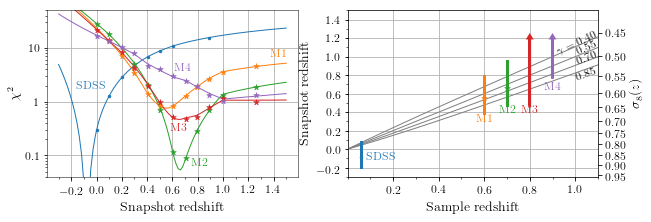

In [7]:
G = growthcalc.Growth(amax=10)

plt.figure(figsize=(9,3))

markers = ('.','*','*','*','*')

left = plt.subplot(121)
right = plt.subplot(122)
left.set_xlabel("Snapshot redshift")
left.set_ylabel("$\chi^2$")
left.grid(True)
left.set_yscale('log')
left.yaxis.set_major_formatter(FormatStrFormatter('%g'))
left.xaxis.set_major_locator(MultipleLocator(0.2))
left.xaxis.set_minor_locator(MultipleLocator(0.1))
right.yaxis.set_minor_locator(MultipleLocator(0.1))
right.xaxis.set_minor_locator(MultipleLocator(0.1))

right.set_ylabel("Snapshot redshift")
right.set_xlabel("Sample redshift")
right.grid(True)
right.set_xlim(0,1.1)
right.set_ylim(0,1.1)
right2 = right.twinx()
right2.set_ylabel("$\sigma_8(z)$")
lab_sig8 = np.arange(0.3,1.01,0.05)
lab_z = G.fid_inv(lab_sig8)

zz = np.linspace(-0.3,1.5,100)

for gamma in [0.4, 0.55, 0.7, 0.85]:
    z_w = G.fid_inv(G(zz, gamma=gamma))
    l, = right.plot(zz, z_w, c='grey', lw=1, zorder=5)

right.text(1.1, 1.15, "$\gamma=%3.2f$"%0.4, color='k', ha='right',va='center', rotation=25,zorder=5,fontsize=12)
right.text(1.1, 1.1, "$%3.2f$"%0.55, color='k', ha='right',va='center', rotation=24,zorder=5,fontsize=12)
right.text(1.1, 0.99, "$%3.2f$"%0.7, color='k', ha='right',va='center', rotation=22,zorder=5,fontsize=12)
right.text(1.1, 0.81,"$%3.2f$"%0.85, color='k', ha='right',va='center', rotation=20,zorder=5,fontsize=12)

print zip(lab_z,lab_sig8)
right2.set_yticks(lab_z)
right2.set_yticklabels("%3.2f"%x for x in lab_sig8)
right2.set_ylim(0, 1.2)
right2.set_xlim(-0.3, 1.5)


right.set_xlim(0,1.1)
right.set_ylim(-0.3,1.5)

right.set_xticks([0.2,0.4,0.6,0.8,1.])


for i,sample in enumerate(samples):

    f = interpolators[i]
    chi2 = []
    r,wp,cmat = data[i]

    for z in zz:
        wpsham = f(1./(1+z))
        d = wp - wpsham
        
        c = chi2_svd(d, cmat, thresh=thresh)
        chi2.append(c)
    chi2 = np.array(chi2)
    like = np.exp(-0.5*(chi2-chi2.min()))
    print "min chi2",sample,chi2.min()
    lines = left.plot(zz,chi2)
        
    chi2_ = []
    zcent = []
    for asham,rsham,wpsham in shamdata[sample]:
        d = wp - wpsham
        c = chi2_svd(d, cmat, thresh=thresh)
        chi2_.append(c)
        zcent.append(1./asham - 1)
    chi2_ = np.array(chi2_)
    print "min chi2",sample,chi2_.min()
    left.scatter(zcent,chi2_, marker=markers[i], color=lines[0].get_color(),zorder=10)
    
    j = chi2.argmin()
    if sample=='sdss':
        left.text(-0.05,1.5,"SDSS",color=lines[0].get_color(),va='bottom',ha='center',fontsize=12)
        right.text(.08, -0.08, "SDSS", color=lines[0].get_color(),va='center',ha='left',fontsize=12)
    elif sample=='L1':
        left.text(zz[-1],chi2[-1]*1.1,'M1',color=lines[0].get_color(),va='bottom',ha='right',fontsize=12)
        right.text(0.6,0.25,"M1", color=lines[0].get_color(),va='bottom',ha='center',fontsize=12)
    elif sample=='L2':
        left.text(zz[j]+0.08,chi2[j],'M2',color=lines[0].get_color(),va='bottom',ha='left',fontsize=12)
        right.text(0.7,0.35,"M2", color=lines[0].get_color(),va='bottom',ha='center',fontsize=12)
    elif sample=='L3':
        left.text(zz[j], chi2[j]*0.9,'M3',color=lines[0].get_color(),va='top',ha='center',fontsize=12)
        right.text(0.8,0.35,"M3", color=lines[0].get_color(),va='bottom',ha='center',fontsize=12)
    elif sample=='L4':
        left.text(zz[50],chi2[50]*1.1,'M4',color=lines[0].get_color(),va='bottom',ha='left',fontsize=12)
        right.text(0.9,0.6,"M4", color=lines[0].get_color(),va='bottom',ha='center',fontsize=12)


    a,b,c = limits(zz, chi2)
    
    zobs = redshifts[sample]
    
    if b is None:  # upper limit
        logging.warning("upper limit! %s %s %s",a,b,c)
        pass
    elif c is None:  # lower limit
        logging.warning("lower limit! %s %s %s",a,b,c)
        plt.arrow(zobs, zz[b], 0, 1.2-zz[b], lw=2.5, head_width=.015, head_length=0.03, color=lines[0].get_color(), zorder=10)
    else:   
        right.plot([zobs, zobs], [zz[b], zz[c]], lw=3,color=lines[0].get_color(), zorder=10)
        right.scatter(zobs, zz[a], marker=markers[i], color=lines[0].get_color(),zorder=10)

right.set_yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0,1.2,1.4])
left.set_ylim(0.04, 50)
right.set_ylim(-0.3,1.5)
right2.set_ylim(-0.3,1.5)

plt.subplots_adjust(left=0.07,right=.92, bottom=0.18)

plt.savefig("../figs/fig8.pdf")